**Generate images from text phrases with VQGAN and CLIP**  (*z+quantize method with augmentations*).

Original Notebook made by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings).

Modified by: Justin John

In [1]:
#@markdown #**Licensed under the MIT License (*Double-click me to read the license agreement*)**
#@markdown ---

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
#@markdown #**Check GPU type**
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---




#@markdown V100 = Excellent (*Available only for Colab Pro Users*)

#@markdown P100 = Very Good

#@markdown T4 = Good

#@markdown K80 = Meh

#@markdown P4 = (Not Recommended) *for heavy A.I Models like COCO, WikiArt 1024, WikiArt 16384, FacesHQ or S-FLCKR*

#@markdown ---

!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-9d3686eb-095a-2bfa-e65e-dac31aa5c9ee)


In [3]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---

import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [ ]:
#@markdown #**Installation of libraries**
# @markdown This cell will take a little while because it has to download several libraries

#@markdown ---

!git clone https://github.com/openai/CLIP
!pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops          
!mkdir steps

In [ ]:
#@markdown #**Selection of models to download**
#@markdown ---
#@markdown **By default, the notebook downloads the 1024 and 16384 models from ImageNet. There are others like COCO-Stuff, WikiArt 1024, WikiArt 16384, FacesHQ or S-FLCKR, which are heavy, and if you are not going to use them it would be pointless to download them, so if you want to use them, simply select the models to download.**

#@markdown ---

imagenet_1024 = True #@param {type:"boolean"}
imagenet_16384 = False #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_1024 = False #@param {type:"boolean"}
wikiart_16384 = False #@param {type:"boolean"}
sflckr = False #@param {type:"boolean"}
openimages_8192 = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.yaml' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.ckpt' #ImageNet 16384
if openimages_8192:
  !curl -L -o vqgan_openimages_f16_8192.yaml -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_openimages_f16_8192.ckpt -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_1024: 
  !curl -L -o wikiart_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart.yaml' #WikiArt 1024
  !curl -L -o wikiart_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart.ckpt' #WikiArt 1024
if wikiart_16384: 
  !curl -L -o wikiart_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart_16384.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart_16384.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR

In [11]:
#@markdown #**Loading libraries and definitions**

import argparse
import math
from pathlib import Path
import sys

sys.path.insert(1, '/content/taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import taming.modules 
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            # K.RandomHorizontalFlip(p=0.5),
            # K.RandomVerticalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            # K.RandomSharpness(0.3,p=0.4),
            # K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5),
            # K.RandomCrop(size=(self.cut_size,self.cut_size), p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
            
)
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):

            # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            # offsetx = torch.randint(0, sideX - size + 1, ())
            # offsety = torch.randint(0, sideY - size + 1, ())
            # cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

            # cutout = transforms.Resize(size=(self.cut_size, self.cut_size))(input)
            
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

## Settings for this run:
Mainly what you will have to modify will be `texts:`, there you can place the text or texts you want to generate (separated with `|`). It is a list because you can put more than one text, and so the AI ​​tries to 'mix' the images, giving the same priority to both texts.

To use an initial image to the model, you just have to upload a file to the Colab environment (in the section on the left), and then modify `init_image:` putting the exact name of the file. Example: `sample.png`

You can also modify the model by changing the lines that say `model:`. Currently ImageNet 1024, ImageNet 16384, WikiArt 1024, WikiArt 16384, S-FLCKR, COCO-Stuff and Open Images are available. To activate them you have to have downloaded them first, and then you can simply select it.

You can also use `target_images`, which is basically putting one or more images on it that the AI ​​will take as a "target", fulfilling the same function as putting text on it. To put more than one you have to use `|` as a separator.

**You can change the width and the height of the image that will be generated according to your liking.**

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
#@markdown #**Parameters**
#@markdown ---

texts = "a picture of a beautiful meadow with flowers " #@param {type:"string"}
width =  300#@param {type:"number"}
height = 300#@param {type:"number"}
model = "vqgan_imagenet_f16_1024" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "vqgan_openimages_f16_8192", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]
images_interval =  50#@param {type:"number"}
init_image = "/content/drive/MyDrive/josh-murr-headshot.jpg"#@param {type:"string"}
target_images = ""#@param {type:"string"}
seed = -1#@param {type:"number"}
max_iterations = 300#@param {type:"number"}

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 'vqgan_openimages_f16_8192':'OpenImages 8912',
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
name_model = model_names[model]     

if seed == -1:
    seed = None
if init_image == "None":
    init_image = None
if target_images == "None" or not target_images:
    target_images = []
else:
    target_images = target_images.split("|")
    target_images = [image.strip() for image in target_images]

texts = [phrase.strip() for phrase in texts.split("|")]
if texts == ['']:
    texts = []


args = argparse.Namespace(
    prompts=texts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.1,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval,
    seed=seed,
)

Using device: cuda:0
Using texts: ['a picture of a beautiful meadow with flowers']
Using seed: 9914609018379321048
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_1024.ckpt


0it [00:00, ?it/s]

i: 0, loss: 1.00638, losses: 1.00638


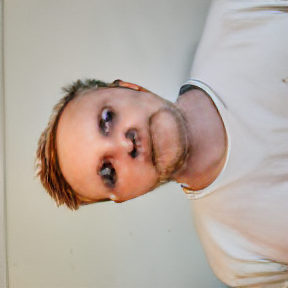

i: 50, loss: 0.821834, losses: 0.821834


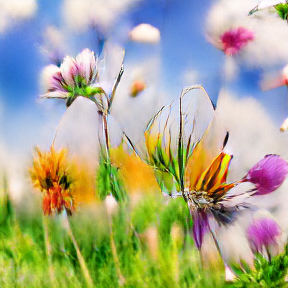

i: 100, loss: 0.810786, losses: 0.810786


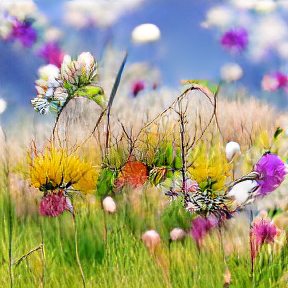

i: 150, loss: 0.75621, losses: 0.75621


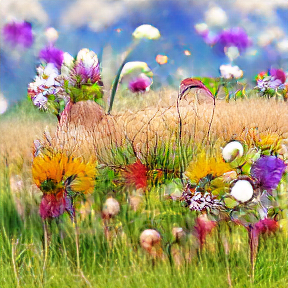

i: 200, loss: 0.744828, losses: 0.744828


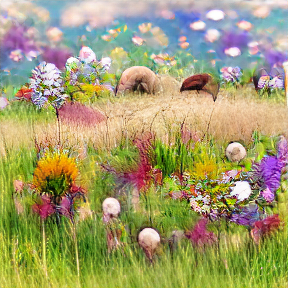

i: 250, loss: 0.740695, losses: 0.740695


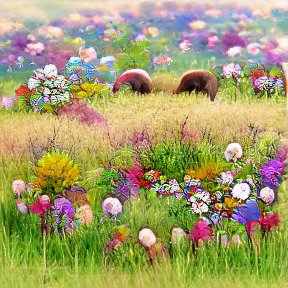

i: 300, loss: 0.764894, losses: 0.764894


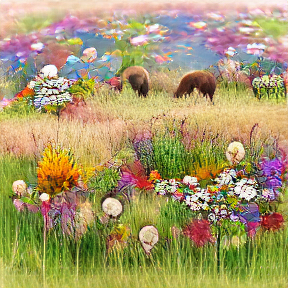

In [20]:
#@markdown #**Fire up the AI**

#@markdown ---
from urllib.request import urlopen

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if texts:
    print('Using texts:', texts)
if target_images:
    print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
# clock=deepcopy(perceptor.visual.positional_embedding.data)
# perceptor.visual.positional_embedding.data = clock/clock.max()
# perceptor.visual.positional_embedding.data=clamp_with_grad(clock,0,1)

cut_size = perceptor.visual.input_resolution

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
# z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
# z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

# normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                            std=[0.229, 0.224, 0.225])

if args.init_image:
    if 'http' in args.init_image:
      img = Image.open(urlopen(args.init_image))
    else:
      img = Image.open(args.init_image)
    pil_image = img.convert('RGB')
    pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    pil_tensor = TF.to_tensor(pil_image)
    z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    # z = one_hot @ model.quantize.embedding.weight
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    z = torch.rand_like(z)*2
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])



pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = Image.open(path)
    pil_image = img.convert('RGB')
    img = resize_image(pil_image, (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    display.display(display.Image('progress.png'))

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
    
    result = []

    if args.init_weight:
        # result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)
        result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*args.init_weight) / 2)
    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    imageio.imwrite('./steps/' + str(i) + '.png', np.array(img))

    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
       
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

i = 0
try:
    with tqdm() as pbar:
        while True:
            train(i)
            if i == max_iterations:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass

In [21]:
#@markdown **Generate a video with the result (You can edit frame rate and stuff by double-clicking this tab)**
init_frame = 1 #This is the frame where the video will start
last_frame = i #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

length = 15 #Desired time of the video in seconds

frames = []
tqdm.write('Generating video...')
for i in range(init_frame,last_frame): #
    frames.append(Image.open("./steps/"+ str(i) +'.png'))

#fps = last_frame/10
fps = np.clip(total_frames/length,min_fps,max_fps)

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()
p.wait()
 
print("The video is now being compressed, wait ...")
p.wait()
print("The video is ready")

Generating video...


  0%|          | 0/299 [00:00<?, ?it/s]

The video is now being compressed, wait ...
The video is ready


In [ ]:
#@markdown **View video in browser**

# @markdown *This process may take a little longer. If you don't want to wait, download it by executing the next cell instead of using this cell.*
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [22]:
#@markdown #**Download the result video**
from google.colab import files
files.download("video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

JS to prevent idle timeout:

Press F12 OR CTRL + SHIFT + I OR right click on this website -> inspect.
Then click on the console tab and paste in the following code.

```javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```